<a href="https://colab.research.google.com/github/Wickstrom/InformationTheoryExperiment/blob/master/NN2DMoons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

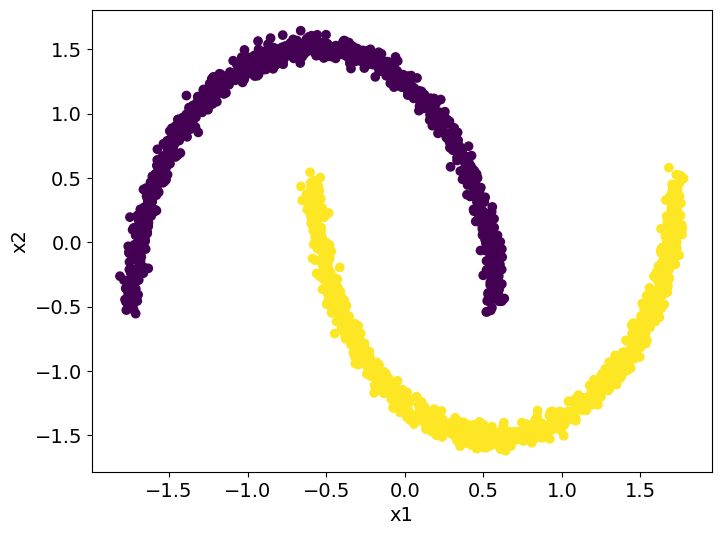

In [1]:
#@title Load packages and data
import sys
import scipy
import random
import torch as th
import numpy as np
import torch.nn as nn
import seaborn as sns
import torch.nn.init as init
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.utils import to_categorical
from torch.distributions.normal import Normal
from sklearn.datasets import make_moons, make_circles
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import accuracy_score
from IPython.display import clear_output
from sklearn.decomposition import PCA


gpu = th.cuda.is_available()
N = 2000


N_tr = 250

mu1 = np.array([0.4, 0.9])
mu2 = np.array([2.0, 1.8])
mu3 = np.array([2.3, 2.3])
mu4 = np.array([2.6, 1.8])

mu5 = np.array([1.5, 1.0])
mu6 = np.array([1.9, 1.0])
mu7 = np.array([1.5, 3.0])
mu8 = np.array([3.3, 2.6])

sigma = np.array([[0.08**2, 0.0], [0.0, 0.08**2]])

x1_tr = np.random.multivariate_normal(mu1, sigma, N_tr)
x2_tr = np.random.multivariate_normal(mu2, sigma, N_tr)
x3_tr = np.random.multivariate_normal(mu3, sigma, N_tr)
x4_tr = np.random.multivariate_normal(mu4, sigma, N_tr)

x5_tr = np.random.multivariate_normal(mu5, sigma, N_tr)
x6_tr = np.random.multivariate_normal(mu6, sigma, N_tr)
x7_tr = np.random.multivariate_normal(mu7, sigma, N_tr)
x8_tr = np.random.multivariate_normal(mu8, sigma, N_tr)

x = np.concatenate((x1_tr, x2_tr, x3_tr, x4_tr,
                    x5_tr, x6_tr, x7_tr, x8_tr))
y = np.concatenate((np.zeros(N_tr), np.zeros(N_tr),
                    np.zeros(N_tr), np.zeros(N_tr),
                    np.ones(N_tr), np.ones(N_tr),
                    np.ones(N_tr), np.ones(N_tr)))

shuffle_idx = random.sample(range(0, 8*N_tr), 8*N_tr)

x_tr = x[shuffle_idx]
y_tr = y[shuffle_idx]

x_tr, y_tr = make_moons(n_samples=N, noise=0.025, random_state=0)
#x_tr, y_tr = make_circles(n_samples=N, noise=0.025, random_state=0, factor=0.4)

x_tr = preprocessing.scale(x_tr)

plt.figure(1, figsize=(8, 6))
plt.scatter(x_tr[:, 0], x_tr[:, 1], c=y_tr)
plt.xlabel('x1', fontsize=14)
plt.ylabel('x2', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

x_tr = th.tensor(x_tr).float().cuda()
y_tr = th.tensor(to_categorical(y_tr)).long().cuda()


In [2]:
#@title DNet
import random
import torch.nn as nn
import torch.nn.init as init


class DNet(nn.Module):
    def __init__(self, activation):
        super(DNet, self).__init__()

        self.activation = activation
        self.a_type = 'relu'

        # First encoder
        self.layer1 = nn.Sequential(
                *([nn.Linear(2, 15),
                   nn.BatchNorm1d(15),
                   self.activation]))

        self.layer2 = nn.Sequential(
                *([nn.Linear(15, 5),
                   nn.BatchNorm1d(5),
                   self.activation]))

        self.layer3 = nn.Sequential(
                *([nn.Linear(5, 3),
                   nn.BatchNorm1d(3),
                   self.activation]))

        self.layer_out = nn.Sequential(
                *([nn.Linear(3, 2)]))


        for m in self.modules():
            self.weight_init(m)


        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):

      layer1 = self.layer1(x)
      layer2 = self.layer2(layer1)
      layer3 = self.layer3(layer2)

      return self.layer_out(layer3), layer3, layer2, layer1

    def make_batches(self, N, batch_size):

        idx = random.sample(range(0, N), N)

        for i in range(0, N, batch_size):
            yield idx[i:i+batch_size]

    def weight_init(self, m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            if self.a_type == 'relu':
                init.kaiming_normal_(m.weight.data, nonlinearity=self.a_type)
                init.constant_(m.bias.data, 0)
            elif self.a_type == 'leaky_relu':
                init.kaiming_normal_(m.weight.data, nonlinearity=self.a_type)
                init.constant_(m.bias.data, 0)
            elif self.a_type == 'tanh':
                g = init.calculate_gain(self.a_type)
                init.xavier_uniform_(m.weight.data, gain=g)
                init.constant_(m.bias.data, 0)
            elif self.a_type == 'sigmoid':
                g = init.calculate_gain(self.a_type)
                init.xavier_uniform_(m.weight.data, gain=g)
                init.constant_(m.bias.data, 0)
            else:
                raise
                return NotImplemented

In [3]:
#@title RBF kernel and entropy

def rbf(x, K_y, sigma=None):

    d = th.norm(x[:, None] - x, dim=2)
    if sigma is None:
        #sigma = CKA(x, K_y, 0.1, 5, 25)
        #sigma = th.median(d)
        sigma = 0.5
    return th.exp(-d ** 2 / (2*sigma ** 2))


def entropy(k, alpha):

    k /= k.trace()                        # Normalize
    eigv = th.linalg.eigh(k)[0].abs()     # Eigendecomposition.
                                          # .abs() is for numerical
                                          # instabilities.
    if alpha == 'one':
        return -(eigv*(eigv.log2())).sum()
    elif alpha == 'max':
        return -th.log2(eigv.max())
    else:
        return (1 / (1-alpha))*th.log2(th.sum(eigv**(alpha)))


def CKA(x, K_y, min_s, max_s, num):

    m = x.shape[0]
    H = th.eye(m, m) - (1 / m) * th.ones(m, m)
    H = H.cuda()
    K_y = th.mm(K_y, H)

    k_loss = []
    k_space = np.linspace(min_s, max_s, num).tolist()
    for sig in k_space:

        K_x = rbf(x, K_y, sig)
        K_x = th.mm(K_x, H)
        k_loss.append(th.sum(K_x * K_y) / (th.norm(K_x) * th.norm(K_y)))

    return k_space[k_loss.index(max(k_loss))]


In [4]:
#@title Plotting functions.

def make_grid_inp(X, Y, model, ns):

    inp = th.tensor(np.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1)), 1)).float().cuda()
    out, _, _, _ = model(inp)
    return model.softmax(out).max(1)[0].cpu().detach().numpy().reshape(ns, ns)


def make_grid_l1(X, Y, model, ns):

    inp = th.tensor(np.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1)), 1)).float().cuda()
    out = model.layer_out(model.layer2(model.layer1(inp)))
    return model.softmax(out).max(1)[0].cpu().detach().numpy().reshape(ns, ns)

def make_grid_l2(X, Y, model, ns):

    inp = th.tensor(np.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1)), 1)).float().cuda()
    out = model.layer_out(model.layer2(inp))
    return model.softmax(out).max(1)[0].cpu().detach().numpy().reshape(ns, ns)


def make_grid_out(X, Y, model, ns):

    inp = th.tensor(np.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1)), 1)).float().cuda()
    out = model.layer_out(inp)
    return model.softmax(inp).max(1)[0].cpu().detach().numpy().reshape(ns, ns)

99 [0.024326326325535774]
99 [0.007829098030924797]
99 [0.007962573319673538]
99 [0.0075693149119615555]
99 [0.009008546359837055]
99 [0.025691280141472816]
99 [0.021529288962483406]
99 [0.009347273968160152]
99 [0.010861938819289207]


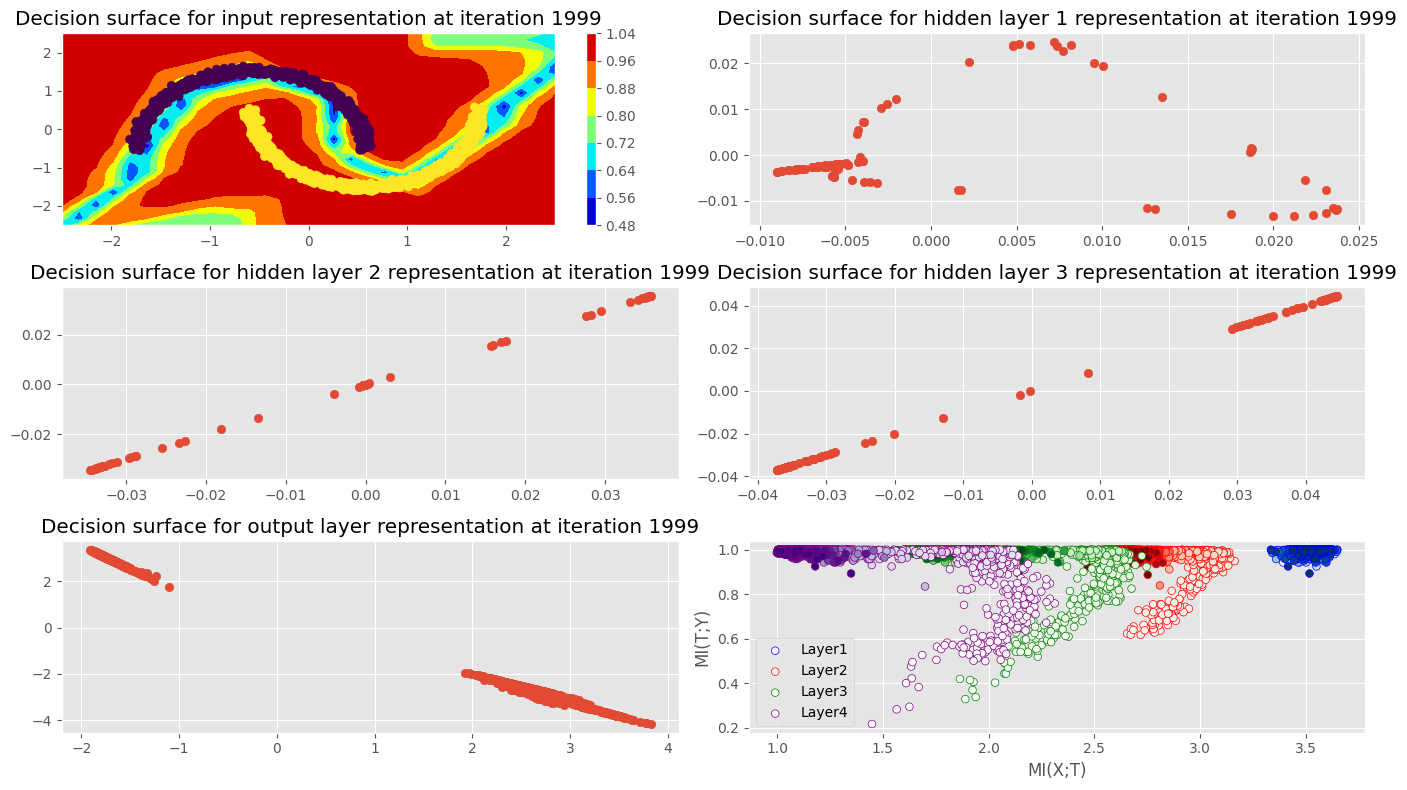

In [15]:
# seed moons 4, 9, 13, 25, 27, 31, 35, 37
# seed circles 1, 8
th.manual_seed(4)
act = nn.ReLU()
model = DNet(act).cuda()

epochs, L, ns, acc, ps = 100, [], 30, [], 0.3
MI_X, MI_Y = [], []
batch_size = 100

optimizer = th.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

video_inp = np.zeros((epochs*20, ns, ns))
video_l1 = np.zeros((epochs*20, ns, ns))
video_l2 = np.zeros((epochs*20, ns, ns))
video_out = np.zeros((epochs*20, ns, ns))


video_r1 = np.zeros((epochs*20, batch_size, 2))
video_r2 = np.zeros((epochs*20, batch_size, 2))
video_r3 = np.zeros((epochs*20, batch_size, 2))
video_rout = np.zeros((epochs*20, batch_size, 2))

video_w1 = np.zeros((epochs*20, 15, 2))
video_w2 = np.zeros((epochs*20, 5, 15))
video_w3 = np.zeros((epochs*20, 3, 5))
video_wout = np.zeros((epochs*20, 2, 3))


for epoch in range(epochs):

    MI_X_b, MI_Y_b = [], []

    batches_tr = list(model.make_batches(N, 100))

    for iteration, idx_tr in enumerate(batches_tr):

        x_tr_b = x_tr[idx_tr]
        y_tr_b = y_tr[idx_tr]
        optimizer.zero_grad()

        out, layer3, layer2, layer1 = model(x_tr_b)

        loss = criterion(out, y_tr_b.argmax(1))
        loss.backward()

        L.append([loss.item()])
        acc.append(accuracy_score(y_tr_b.argmax(1).cpu().detach().numpy(),
                                  out.argmax(1).cpu().detach().numpy()))
        optimizer.step()
        print(epoch, L[-1])

        if iteration % 10 == 0 and epoch != 0:
          clear_output()


        # Compute rbf kernel for input, labels and each hidden layer.
        K_y = th.matmul(y_tr_b.float(), y_tr_b.float().T)
        K_x = rbf(x_tr_b, K_y).cpu()
        layers = [rbf(layer1, K_y).cpu(), rbf(layer2, K_y).cpu(), rbf(layer3, K_y).cpu(), rbf(model.softmax(out), K_y, 0.1).cpu()]

        alpha = 'one'
        MI_X.append([entropy(K_x, alpha)+entropy(K_l, alpha)-entropy(K_x*K_l, alpha) for K_l in layers])
        MI_Y.append([entropy(K_y.cpu(), alpha)+entropy(K_l, alpha)-entropy(K_y.cpu()*K_l, alpha) for K_l in layers])

        video_rout[epoch*20+iteration] = PCA(n_components=2).fit_transform(layers[3].cpu().detach().numpy())
        video_r3[epoch*20+iteration] = PCA(n_components=2).fit_transform(layers[2].cpu().detach().numpy())
        video_r2[epoch*20+iteration] = PCA(n_components=2).fit_transform(layers[1].cpu().detach().numpy())
        video_r1[epoch*20+iteration] = PCA(n_components=2).fit_transform(layers[0].cpu().detach().numpy())

        pred, layer3, layer2, layer1 = model(x_tr)

        video_w1[epoch*20+iteration] = model.layer1[0].weight.cpu().detach().numpy()
        video_w2[epoch*20+iteration] = model.layer2[0].weight.cpu().detach().numpy()
        video_w3[epoch*20+iteration] = model.layer3[0].weight.cpu().detach().numpy()
        video_wout[epoch*20+iteration] = model.layer_out[0].weight.cpu().detach().numpy()

        x_vals_inp = np.linspace(-2.5, 2.5, ns).reshape(ns, 1)
        y_vals_inp = np.linspace(-2.5, 2.5, ns).reshape(ns, 1)
        X_inp, Y_inp = np.meshgrid(x_vals_inp, y_vals_inp)

        #l1_x_max = layer1.max(0)[0][0].cpu().detach().numpy()
        #l1_y_max = layer1.max(0)[0][1].cpu().detach().numpy()
        #l1_x_min = layer1.min(0)[0][0].cpu().detach().numpy()
        #l1_y_min = layer1.min(0)[0][1].cpu().detach().numpy()
        #x_vals_l1 = np.linspace(l1_x_min-ps, l1_x_max+ps, ns).reshape(ns, 1)
        #y_vals_l1 = np.linspace(l1_y_min-ps, l1_y_max+ps, ns).reshape(ns, 1)
        #X_l1, Y_l1 = np.meshgrid(x_vals_l1, y_vals_l1)

        #l2_x_max = layer2.max(0)[0][0].cpu().detach().numpy()
        #l2_y_max = layer2.max(0)[0][1].cpu().detach().numpy()
        #l2_x_min = layer2.min(0)[0][0].cpu().detach().numpy()
        #l2_y_min = layer2.min(0)[0][1].cpu().detach().numpy()
        #x_vals_l2 = np.linspace(l2_x_min-ps, l2_x_max+ps, ns).reshape(ns, 1)
        #y_vals_l2 = np.linspace(l2_y_min-ps, l2_y_max+ps, ns).reshape(ns, 1)
        #X_l2, Y_l2 = np.meshgrid(x_vals_l2, y_vals_l2)

        out_x_max = pred.max(0)[0][0].cpu().detach().numpy()
        out_y_max = pred.max(0)[0][1].cpu().detach().numpy()
        out_x_min = pred.min(0)[0][0].cpu().detach().numpy()
        out_y_min = pred.min(0)[0][1].cpu().detach().numpy()
        x_vals_out = np.linspace(out_x_min-ps, out_x_max+ps, ns).reshape(ns, 1)
        y_vals_out = np.linspace(out_y_min-ps, out_y_max+ps, ns).reshape(ns, 1)
        X_out, Y_out = np.meshgrid(x_vals_out, y_vals_out)

        video_inp[epoch*20+iteration] = make_grid_inp(X_inp, Y_inp, model, ns)
        #video_l1[epoch*20+iteration] = make_grid_l1(X_l1, Y_l1, model, ns)
        #video_l2[epoch*20+iteration] = make_grid_l2(X_l2, Y_l2, model, ns)
        #video_out[epoch*20+iteration] = make_grid_out(X_out, Y_out, model, ns)

    #MI_X.append(np.array(MI_X_b).mean(0))
    #MI_Y.append(np.array(MI_Y_b).mean(0))

plt.figure(1, figsize=(14, 8))

plt.subplot(3, 2, 1)
plt.contourf(X_inp, Y_inp, video_inp[-1], cmap='jet')
plt.colorbar()
plt.scatter(x_tr[:, 0].cpu().detach().numpy(), x_tr[:, 1].cpu().detach().numpy(), c=y_tr.argmax(1).cpu().detach().numpy())
plt.title('Decision surface for input representation at iteration '+str(epoch*20+iteration))
plt.subplot(3, 2, 2)
#plt.contourf(X_l1, Y_l1, video_l1[-1], cmap='jet')
#plt.colorbar()
plt.scatter(video_r1[-1, :, 0], video_r1[-1, :, 1])#, c=y_tr.argmax(1).cpu().detach().numpy())
plt.title('Decision surface for hidden layer 1 representation at iteration '+str(epoch*20+iteration))
plt.subplot(3, 2, 3)
#plt.contourf(X_l2, Y_l2, video_l2[-1], cmap='jet')
#lt.colorbar()
plt.scatter(video_r2[-1, :, 0], video_r2[-1, :, 0])#, c=y_tr.argmax(1).cpu().detach().numpy())
plt.title('Decision surface for hidden layer 2 representation at iteration '+str(epoch*20+iteration))
plt.subplot(3, 2, 4)
plt.scatter(video_r3[-1, :, 0], video_r3[-1, :, 0])#, c=y_tr.argmax(1).cpu().detach().numpy())
plt.title('Decision surface for hidden layer 3 representation at iteration '+str(epoch*20+iteration))
plt.subplot(3, 2, 5)
#plt.contourf(X_out, Y_out, video_out[-1], cmap='jet')
#plt.colorbar()
plt.scatter(pred.cpu().detach().numpy()[:, 0], pred.cpu().detach().numpy()[:, 1])#, c=y_tr.argmax(1).cpu().detach().numpy())
plt.title('Decision surface for output layer representation at iteration '+str(epoch*20+iteration))
plt.subplot(3, 2, 6)

MI_X = th.tensor(MI_X).numpy(force=True)
MI_Y = th.tensor(MI_Y).numpy(force=True)
c_lab = ['Blues', 'Reds', 'Greens', 'Purples']

for i in range(4):
    plt.scatter(MI_X[:, i], MI_Y[:, i], cmap=c_lab[i], s=30, edgecolor=c_lab[i][:-1],
                c=np.arange(0, MI_X.shape[0], 1), label='Layer'+str(i+1))

plt.xlabel('MI(X;T)')
plt.ylabel('MI(T;Y)')
plt.legend()
plt.tight_layout()
plt.show()

Blue
Red
Green
Purple


<ipython-input-16-45b20d9295be>:19: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


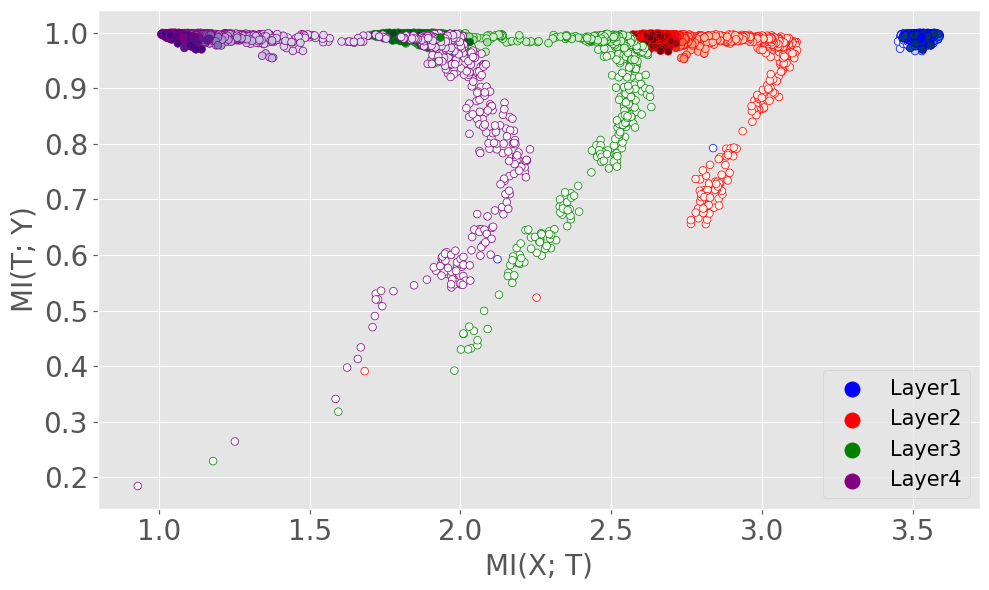

In [16]:
def sma(arr, n):
   weights = np.ones(n) / n
   return np.convolve(weights, arr, mode='same')

plt.style.use('ggplot')
c_lab = ['Blues', 'Reds', 'Greens', 'Purples']
plt.figure(1, figsize=(10, 6))
for i in range(4):
    plt.scatter(sma(MI_X[:, i], n=5)[:-10], sma(MI_Y[:, i], n=5)[:-10], cmap=c_lab[i], s=30, edgecolor=c_lab[i][:-1],
                c=np.arange(0, MI_X.shape[0]-10, 1))

c_lab = ['Blue', 'Red', 'Green', 'Purple']
for i in range(4):
    print(c_lab[i])
    plt.scatter(MI_X[-1, i],
                MI_Y[-1, i], color=c_lab[i], s=30, label='Layer'+str(i+1))

lgnd = plt.legend(prop={'size': 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([120])

plt.xlabel('MI(X; T)', fontsize=20)
plt.ylabel('MI(T; Y)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()

199 [0.003515893593430519]
199 [0.0031217082869261503]
199 [0.003348258323967457]
199 [0.0028484282083809376]
199 [0.004383556079119444]
199 [0.004510805010795593]
199 [0.002781674498692155]
199 [0.002738064620643854]
199 [0.003176579251885414]


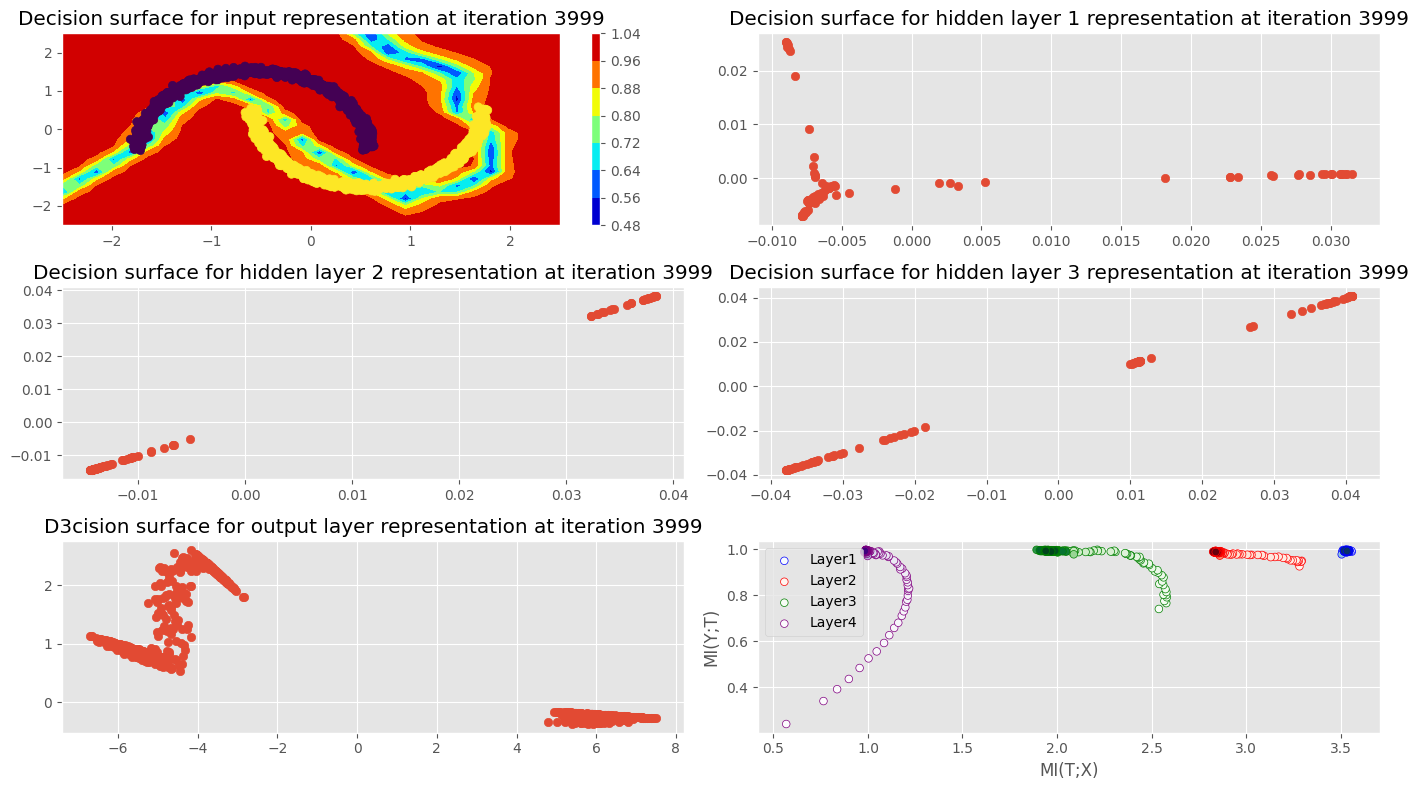

In [19]:
#@title Messy experiemnt

th.manual_seed(0)
act = nn.LeakyReLU()
model = DNet(act).cuda()

epochs, L, ns, acc, ps = 200, [], 30, [], 0.3
MI_X, MI_Y = [], []
batch_size = 100

optimizer = th.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

video_inp = np.zeros((epochs*20, ns, ns))
video_l1 = np.zeros((epochs*20, ns, ns))
video_l2 = np.zeros((epochs*20, ns, ns))
video_out = np.zeros((epochs*20, ns, ns))


video_r1 = np.zeros((epochs*20, batch_size, 2))
video_r2 = np.zeros((epochs*20, batch_size, 2))
video_r3 = np.zeros((epochs*20, batch_size, 2))
video_rout = np.zeros((epochs*20, batch_size, 2))

video_w1 = np.zeros((epochs*20, 15, 2))
video_w2 = np.zeros((epochs*20, 5, 15))
video_w3 = np.zeros((epochs*20, 3, 5))
video_wout = np.zeros((epochs*20, 2, 3))


for epoch in range(epochs):

    MI_X_b, MI_Y_b = [], []

    batches_tr = list(model.make_batches(N, 100))

    for iteration, idx_tr in enumerate(batches_tr):

        x_tr_b = x_tr[idx_tr]
        y_tr_b = y_tr[idx_tr]
        optimizer.zero_grad()

        out, layer3, layer2, layer1 = model(x_tr_b)

        loss = criterion(out, y_tr_b.argmax(1))
        loss.backward()

        L.append([loss.item()])
        acc.append(accuracy_score(y_tr_b.argmax(1).cpu().detach().numpy(),
                                  out.argmax(1).cpu().detach().numpy()))
        optimizer.step()
        print(epoch, L[-1])

        if iteration % 10 == 0 and epoch != 0:
          clear_output()


        # Compute rbf kernel for input, labels and each hidden layer.
        K_y = th.matmul(y_tr_b.float(), y_tr_b.float().T).cpu()
        K_x = rbf(x_tr_b.cpu(), K_y)
        layers = [rbf(layer1, K_y).cpu(), rbf(layer2, K_y).cpu(), rbf(layer3, K_y).cpu(), rbf(model.softmax(out), K_y).cpu()]

        MI_X_b.append([entropy(K_x, alpha)+entropy(K_l, alpha)-entropy(K_x*K_l, alpha) for K_l in layers])
        MI_Y_b.append([entropy(K_y.cpu(), alpha)+entropy(K_l, alpha)-entropy(K_y.cpu()*K_l, alpha) for K_l in layers])

        video_rout[epoch*20+iteration] = PCA(n_components=2).fit_transform(layers[3].cpu().detach().numpy())
        video_r3[epoch*20+iteration] = PCA(n_components=2).fit_transform(layers[2].cpu().detach().numpy())
        video_r2[epoch*20+iteration] = PCA(n_components=2).fit_transform(layers[1].cpu().detach().numpy())
        video_r1[epoch*20+iteration] = PCA(n_components=2).fit_transform(layers[0].cpu().detach().numpy())

        pred, layer3, layer2, layer1 = model(x_tr)

        video_w1[epoch*20+iteration] = model.layer1[0].weight.cpu().detach().numpy()
        video_w2[epoch*20+iteration] = model.layer2[0].weight.cpu().detach().numpy()
        video_w3[epoch*20+iteration] = model.layer3[0].weight.cpu().detach().numpy()
        video_wout[epoch*20+iteration] = model.layer_out[0].weight.cpu().detach().numpy()

        x_vals_inp = np.linspace(-2.5, 2.5, ns).reshape(ns, 1)
        y_vals_inp = np.linspace(-2.5, 2.5, ns).reshape(ns, 1)
        X_inp, Y_inp = np.meshgrid(x_vals_inp, y_vals_inp)

        #l1_x_max = layer1.max(0)[0][0].cpu().detach().numpy()
        #l1_y_max = layer1.max(0)[0][1].cpu().detach().numpy()
        #l1_x_min = layer1.min(0)[0][0].cpu().detach().numpy()
        #l1_y_min = layer1.min(0)[0][1].cpu().detach().numpy()
        #x_vals_l1 = np.linspace(l1_x_min-ps, l1_x_max+ps, ns).reshape(ns, 1)
        #y_vals_l1 = np.linspace(l1_y_min-ps, l1_y_max+ps, ns).reshape(ns, 1)
        #X_l1, Y_l1 = np.meshgrid(x_vals_l1, y_vals_l1)

        #l2_x_max = layer2.max(0)[0][0].cpu().detach().numpy()
        #l2_y_max = layer2.max(0)[0][1].cpu().detach().numpy()
        #l2_x_min = layer2.min(0)[0][0].cpu().detach().numpy()
        #l2_y_min = layer2.min(0)[0][1].cpu().detach().numpy()
        #x_vals_l2 = np.linspace(l2_x_min-ps, l2_x_max+ps, ns).reshape(ns, 1)
        #y_vals_l2 = np.linspace(l2_y_min-ps, l2_y_max+ps, ns).reshape(ns, 1)
        #X_l2, Y_l2 = np.meshgrid(x_vals_l2, y_vals_l2)


        out_x_max = pred.max(0)[0][0].cpu().detach().numpy()
        out_y_max = pred.max(0)[0][1].cpu().detach().numpy()
        out_x_min = pred.min(0)[0][0].cpu().detach().numpy()
        out_y_min = pred.min(0)[0][1].cpu().detach().numpy()
        x_vals_out = np.linspace(out_x_min-ps, out_x_max+ps, ns).reshape(ns, 1)
        y_vals_out = np.linspace(out_y_min-ps, out_y_max+ps, ns).reshape(ns, 1)
        X_out, Y_out = np.meshgrid(x_vals_out, y_vals_out)

        video_inp[epoch*20+iteration] = make_grid_inp(X_inp, Y_inp, model, ns)
        #video_l1[epoch*20+iteration] = make_grid_l1(X_l1, Y_l1, model, ns)
        #video_l2[epoch*20+iteration] = make_grid_l2(X_l2, Y_l2, model, ns)
        #video_out[epoch*20+iteration] = make_grid_out(X_out, Y_out, model, ns)

    MI_X.append(th.tensor(MI_X_b).mean(0).numpy(force=True))
    MI_Y.append(th.tensor(MI_Y_b).mean(0).numpy(force=True))


plt.figure(1, figsize=(14, 8))

plt.subplot(3, 2, 1)
plt.contourf(X_inp, Y_inp, video_inp[-1], cmap='jet')
plt.colorbar()
plt.scatter(x_tr[:, 0].cpu().detach().numpy(), x_tr[:, 1].cpu().detach().numpy(), c=y_tr.argmax(1).cpu().detach().numpy())
plt.title('Decision surface for input representation at iteration '+str(epoch*20+iteration))
plt.subplot(3, 2, 2)
#plt.contourf(X_l1, Y_l1, video_l1[-1], cmap='jet')
#plt.colorbar()
plt.scatter(video_r1[-1, :, 0], video_r1[-1, :, 1])#, c=y_tr.argmax(1).cpu().detach().numpy())
plt.title('Decision surface for hidden layer 1 representation at iteration '+str(epoch*20+iteration))
plt.subplot(3, 2, 3)
#plt.contourf(X_l2, Y_l2, video_l2[-1], cmap='jet')
#lt.colorbar()
plt.scatter(video_r2[-1, :, 0], video_r2[-1, :, 0])#, c=y_tr.argmax(1).cpu().detach().numpy())
plt.title('Decision surface for hidden layer 2 representation at iteration '+str(epoch*20+iteration))
plt.subplot(3, 2, 4)
plt.scatter(video_r3[-1, :, 0], video_r3[-1, :, 0])#, c=y_tr.argmax(1).cpu().detach().numpy())
plt.title('Decision surface for hidden layer 3 representation at iteration '+str(epoch*20+iteration))
plt.subplot(3, 2, 5)
#plt.contourf(X_out, Y_out, video_out[-1], cmap='jet')
#plt.colorbar()
plt.scatter(pred.cpu().detach().numpy()[:, 0], pred.cpu().detach().numpy()[:, 1])#, c=y_tr.argmax(1).cpu().detach().numpy())
plt.title('D3cision surface for output layer representation at iteration '+str(epoch*20+iteration))
plt.subplot(3, 2, 6)

MI_X = np.array(MI_X)
MI_Y = np.array(MI_Y)
c_lab = ['Blues', 'Reds', 'Greens', 'Purples']

for i in range(4):
    plt.scatter(MI_X[:, i], MI_Y[:, i], cmap=c_lab[i], s=30, edgecolor=c_lab[i][:-1],
                c=np.arange(0, MI_X.shape[0], 1), label='Layer'+str(i+1))

plt.xlabel('MI(T;X)')
plt.ylabel('MI(Y;T)')
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
#@title Creating figures and downloaindg images
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
mi_i = 0
c_lab = ['Blues', 'Reds', 'Greens', 'Purples']
for i in range(epochs*20):

    plt.figure(1, figsize=(14, 8))

    plt.subplot(3, 2, 1)
    plt.contourf(X_inp, Y_inp, video_inp[i], cmap='jet')
    plt.colorbar()
    plt.scatter(x_tr[:, 0].cpu().detach().numpy(), x_tr[:, 1].cpu().detach().numpy(), c=y_tr.argmax(1).cpu().detach().numpy())
    plt.title('Decision surface for input representation at iteration '+str(i))
    plt.subplot(3, 2, 2)
    #plt.contourf(X_l1, Y_l1, video_l1[-1], cmap='jet')
    #plt.colorbar()
    plt.scatter(video_r1[i, :, 0], video_r1[i, :, 1], c=y_tr.argmax(1).cpu().detach().numpy())
    plt.title('Decision surface for hidden layer 1 representation at iteration '+str(i))
    plt.subplot(3, 2, 3)
    #plt.contourf(X_l2, Y_l2, video_l2[-1], cmap='jet')
    #lt.colorbar()
    plt.scatter(video_r2[i, :, 0], video_r2[i, :, 0], c=y_tr.argmax(1).cpu().detach().numpy())
    plt.title('Decision surface for hidden layer 2 representation at iteration '+str(i))
    plt.subplot(3, 2, 4)
    plt.scatter(video_r3[i, :, 0], video_r3[i, :, 0], c=y_tr.argmax(1).cpu().detach().numpy())
    plt.title('Decision surface for hidden layer 3 representation at iteration '+str(i))
    plt.subplot(3, 2, 5)
    #plt.contourf(X_out, Y_out, video_out[-1], cmap='jet')
    #plt.colorbar()
    plt.scatter(video_rout[i, :, 0], video_rout[i, :, 0], c=y_tr.argmax(1).cpu().detach().numpy())
    plt.title('Decision surface for output layer representation at iteration '+str(i))
    plt.subplot(3, 2, 6)

    if i % 20 == 0 and i != 0:
        mi_i += 1

    for j in range(4):
        plt.scatter(MI_X[:mi_i, j], MI_Y[:mi_i, j], cmap=c_lab[j], s=30, edgecolor=c_lab[j][:-1],
                    c=np.arange(0, mi_i, 1), label='Layer'+str(j+1))

    plt.xlabel('MI(T;X)')
    plt.ylabel('MI(Y;T)')
    plt.legend()
    plt.tight_layout()

    plt.savefig('img'+str(i)+'.png', format='png', dpi=100)
    file_name = "/content/img"+str(i)+".png"
    files.download(file_name)
    plt.clf()



MessageError: ignored